## Profile Likelihood for Poisson Regression

For each fixed value of $\beta$ on grid, the log-likelihood for a single observation is

$$
\ell_i(\beta)
= \log p(y_i \mid x_i, \beta)
= y_i \,\bigl(\beta\,x_i\bigr)
- \exp\!\bigl(\beta\,x_i\bigr)
- \log\bigl(y_i!\bigr).
$$

Since $\beta$ is the only parameter, the **profile log-likelihood** is just the sum over all \(n\) observations:

$$
\ell(\beta)
= \sum_{i=1}^n \ell_i(\beta)
= \sum_{i=1}^n \Bigl[y_i(\beta\,x_i) \;-\; e^{\beta\,x_i} \;-\; \log(y_i!)\Bigr].
$$



In [2]:
import jax.numpy as jnp
import jax.random as random
import numpy as np
import pandas as pd
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import arviz as az
from scipy.special import gammaln

def simulate_profile_likelihoods(
    K=5, S=8, O=8, n_obs=100,
    beta_true=None, grid=None, seed=0
):
    """
    Simulate profile-likelihood curves for a K-component Poisson regression mixture,
    and also return the true mixture proportions for each source.

    Returns
    -------
    df : pandas.DataFrame
        Long-format DataFrame with columns ['source','outcome','point','value'].
    true_pis : numpy.ndarray
        Array of shape (S, K) giving the true component proportions for each source.
    """
    rng = np.random.default_rng(seed)
    if beta_true is None:
        beta_true = np.linspace(-1, 1, K)
    beta_true = np.asarray(beta_true)
    if grid is None:
        raise ValueError("Provide grid array via `grid` argument")
    
    # 1) Draw source-specific mixture proportions
    true_pis = rng.dirichlet(np.ones(K) * 2.0, size=S)  # shape (S, K)
    
    records = []
    for s in range(1, S + 1):
        pi_s = true_pis[s - 1]
        for o in range(1, O + 1):
            # assign each obs to a component
            z = rng.choice(K, size=n_obs, p=pi_s)
            # simulate covariate and response
            x = rng.uniform(-1, 1, size=n_obs)
            lam = np.exp(beta_true[z] * x)
            y = rng.poisson(lam)
            # compute profile log-likelihood over grid
            for b in grid:
                logp = y * (b * x) - np.exp(b * x) - gammaln(y + 1)
                records.append({
                    'source': s,
                    'outcome': o,
                    'point': b,
                    'value': np.sum(logp)
                })
    
    df = pd.DataFrame.from_records(records)
    return df, true_pis

# load your grid
orig = pd.read_csv("profileLikelihoods_NCs_long.csv")
grid_pts = np.sort(orig.loc[orig['source']==2, 'point'].unique())

# simulate with your specified betas
df_sim, true_pis = simulate_profile_likelihoods(
    K=5,
    S=8,
    O=8,
    n_obs=100,
    beta_true=[-0.5, -0.2, 0.2, 0.5, 1.0],
    grid=grid_pts,
    seed=42
)

df_sim.to_csv("simulated_profileLikelihoods_poisson.csv", index=False)


For each outcome $o=1,\dots,O$ and observation $i=1,\dots,n$:  

\begin{aligned}
z_{s,o,i} &\sim \mathrm{Categorical}(\pi_s),\\
x_{s,o,i} &\sim \mathrm{Uniform}(-1,1),\\
y_{s,o,i} &= \beta_{\,z_{s,o,i}}\,x_{s,o,i} + \varepsilon_{s,o,i},\quad
\varepsilon_{s,o,i}\sim\mathcal{N}(0,\sigma^2).
\end{aligned}

At each candidate \(b\) in the grid:  
$$
\ell_{s,o}(b)
=
\sum_{i=1}^n \log \bigl[\mathcal{N}(y_{s,o,i}\mid b\,x_{s,o,i},\,\sigma^2)\bigr]
=
-\frac{n}{2}\log(2\pi\sigma^2)
\;-\;
\frac{1}{2\sigma^2}\sum_{i=1}^n\bigl(y_{s,o,i}-b\,x_{s,o,i}\bigr)^2.
$$



In [3]:
def simulate_profile_likelihoods_linreg(
    K=5,
    S=8,
    O=8,
    n_obs=100,
    beta_true=None,
    grid=None,
    sigma_noise=1.0,
    seed=0
):
    """
    Simulate profile-likelihood curves for a K-component linear regression mixture,
    and return the true mixture proportions for each source.

    Model for each observation i:
        x_i ~ Uniform(-1, 1)
        z_i ~ Categorical(pi_s)              # mixture component index
        y_i = beta_true[z_i] * x_i + epsilon_i,   epsilon_i ~ N(0, sigma_noise^2)

    Log-likelihood at beta (on the grid) is:
        ℓ(beta) = -0.5 * [n_obs * log(2πσ^2) + Σ_i (y_i - beta * x_i)^2 / σ^2]

    Returns
    -------
    df : pandas.DataFrame
        Long-format DataFrame with columns ['source','outcome','point','value'].
    true_pis : numpy.ndarray
        Array of shape (S, K) giving the true component proportions for each source.
    """
    rng = np.random.default_rng(seed)
    if beta_true is None:
        beta_true = np.linspace(-1, 1, K)
    beta_true = np.asarray(beta_true)
    if grid is None:
        raise ValueError("Provide `grid` array of beta values")

    # Draw source-specific mixture proportions
    true_pis = rng.dirichlet(np.ones(K) * 2.0, size=S)  # shape (S, K)

    records = []
    const_term = -0.5 * (n_obs * np.log(2 * np.pi * sigma_noise**2))
    for s in range(1, S + 1):
        pi_s = true_pis[s - 1]
        for o in range(1, O + 1):
            # assign each obs to a component
            z = rng.choice(K, size=n_obs, p=pi_s)
            # simulate covariate and response
            x = rng.uniform(-1, 1, size=n_obs)
            y = beta_true[z] * x + rng.normal(0, sigma_noise, size=n_obs)
            # compute profile log-likelihood over grid
            for b in grid:
                resid_sq = (y - b * x) ** 2
                ll = const_term - 0.5 * np.sum(resid_sq) / (sigma_noise**2)
                records.append({
                    'source': s,
                    'outcome': o,
                    'point': b,
                    'value': ll
                })

    df = pd.DataFrame.from_records(records)
    return df, true_pis

df_sim, true_pis = simulate_profile_likelihoods(
    K=5,
    S=8,
    O=8,
    n_obs=100,
    beta_true=[-0.5, -0.2, 0.2, 0.5, 1.0],
    grid=grid_pts,
    seed=42
)

df_sim.to_csv("simulated_profileLikelihoods_linreg.csv", index=False)
true_pis

array([[0.182076  , 0.2467942 , 0.15991495, 0.14319025, 0.2680246 ],
       [0.16226678, 0.21711215, 0.20262703, 0.2848007 , 0.13319334],
       [0.35248377, 0.10889546, 0.22777007, 0.2097213 , 0.10112939],
       [0.31192199, 0.18316285, 0.09769391, 0.33921295, 0.06800829],
       [0.08925351, 0.17176974, 0.28885723, 0.25510165, 0.19501787],
       [0.1023434 , 0.28595577, 0.3380555 , 0.19739144, 0.07625389],
       [0.19963775, 0.2925956 , 0.13294668, 0.32160435, 0.05321562],
       [0.08485659, 0.21323099, 0.1347426 , 0.29983717, 0.26733264]])

In [4]:
N_sources = 8
source_outcome_data = {}
for s in range(1, N_sources+1):
    df_s = df_sim[df_sim["source"]==s]
    outcome_list = []
    for o in sorted(df_s["outcome"].unique()):
        arr = df_s[df_s["outcome"]==o][["point","value"]].to_numpy()
        outcome_list.append(jnp.array(arr))
    source_outcome_data[s] = outcome_list

num_outcomes_dict = {s: len(source_outcome_data[s])
                     for s in range(2, N_sources+1)}

### check the posterior-predictive density. $y$ and $\beta$

sample: 100%|██████████| 25000/25000 [06:20<00:00, 65.71it/s, 334 steps of size 1.08e-02. acc. prob=0.76] 



                  mean       std    median      5.0%     95.0%     n_eff     r_hat
      alpha0      1.00      0.36      0.95      0.46      1.53   1622.40      1.00
      beta_2      0.04      0.07      0.02     -0.06      0.15   2571.78      1.00
      beta_3     -0.01      0.05     -0.01     -0.09      0.06   2757.67      1.00
      beta_4      0.21      0.06      0.22      0.11      0.30   2166.70      1.00
      beta_5      0.41      0.08      0.43      0.28      0.53   2852.26      1.00
      beta_6      0.19      0.07      0.20      0.07      0.28   2923.93      1.00
      beta_7      0.09      0.08      0.08     -0.03      0.22   3072.80      1.00
      beta_8      0.38      0.08      0.39      0.26      0.51   2980.14      1.00
beta_tilt[0]      0.36      0.24      0.40      0.02      0.67     32.95      1.01
beta_tilt[1]      0.34      0.22      0.29      0.04      0.67     42.12      1.00
beta_tilt[2]      0.25      0.14      0.22      0.05      0.46    399.71      1.00
bet

array([[<Axes: title={'center': 'alpha0'}>,
        <Axes: title={'center': 'alpha0'}>],
       [<Axes: title={'center': 'beta_2'}>,
        <Axes: title={'center': 'beta_2'}>],
       [<Axes: title={'center': 'beta_3'}>,
        <Axes: title={'center': 'beta_3'}>],
       [<Axes: title={'center': 'beta_4'}>,
        <Axes: title={'center': 'beta_4'}>],
       [<Axes: title={'center': 'beta_5'}>,
        <Axes: title={'center': 'beta_5'}>],
       [<Axes: title={'center': 'beta_6'}>,
        <Axes: title={'center': 'beta_6'}>],
       [<Axes: title={'center': 'beta_7'}>,
        <Axes: title={'center': 'beta_7'}>],
       [<Axes: title={'center': 'beta_8'}>,
        <Axes: title={'center': 'beta_8'}>],
       [<Axes: title={'center': 'beta_tilt'}>,
        <Axes: title={'center': 'beta_tilt'}>],
       [<Axes: title={'center': 'gamma'}>,
        <Axes: title={'center': 'gamma'}>],
       [<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': '

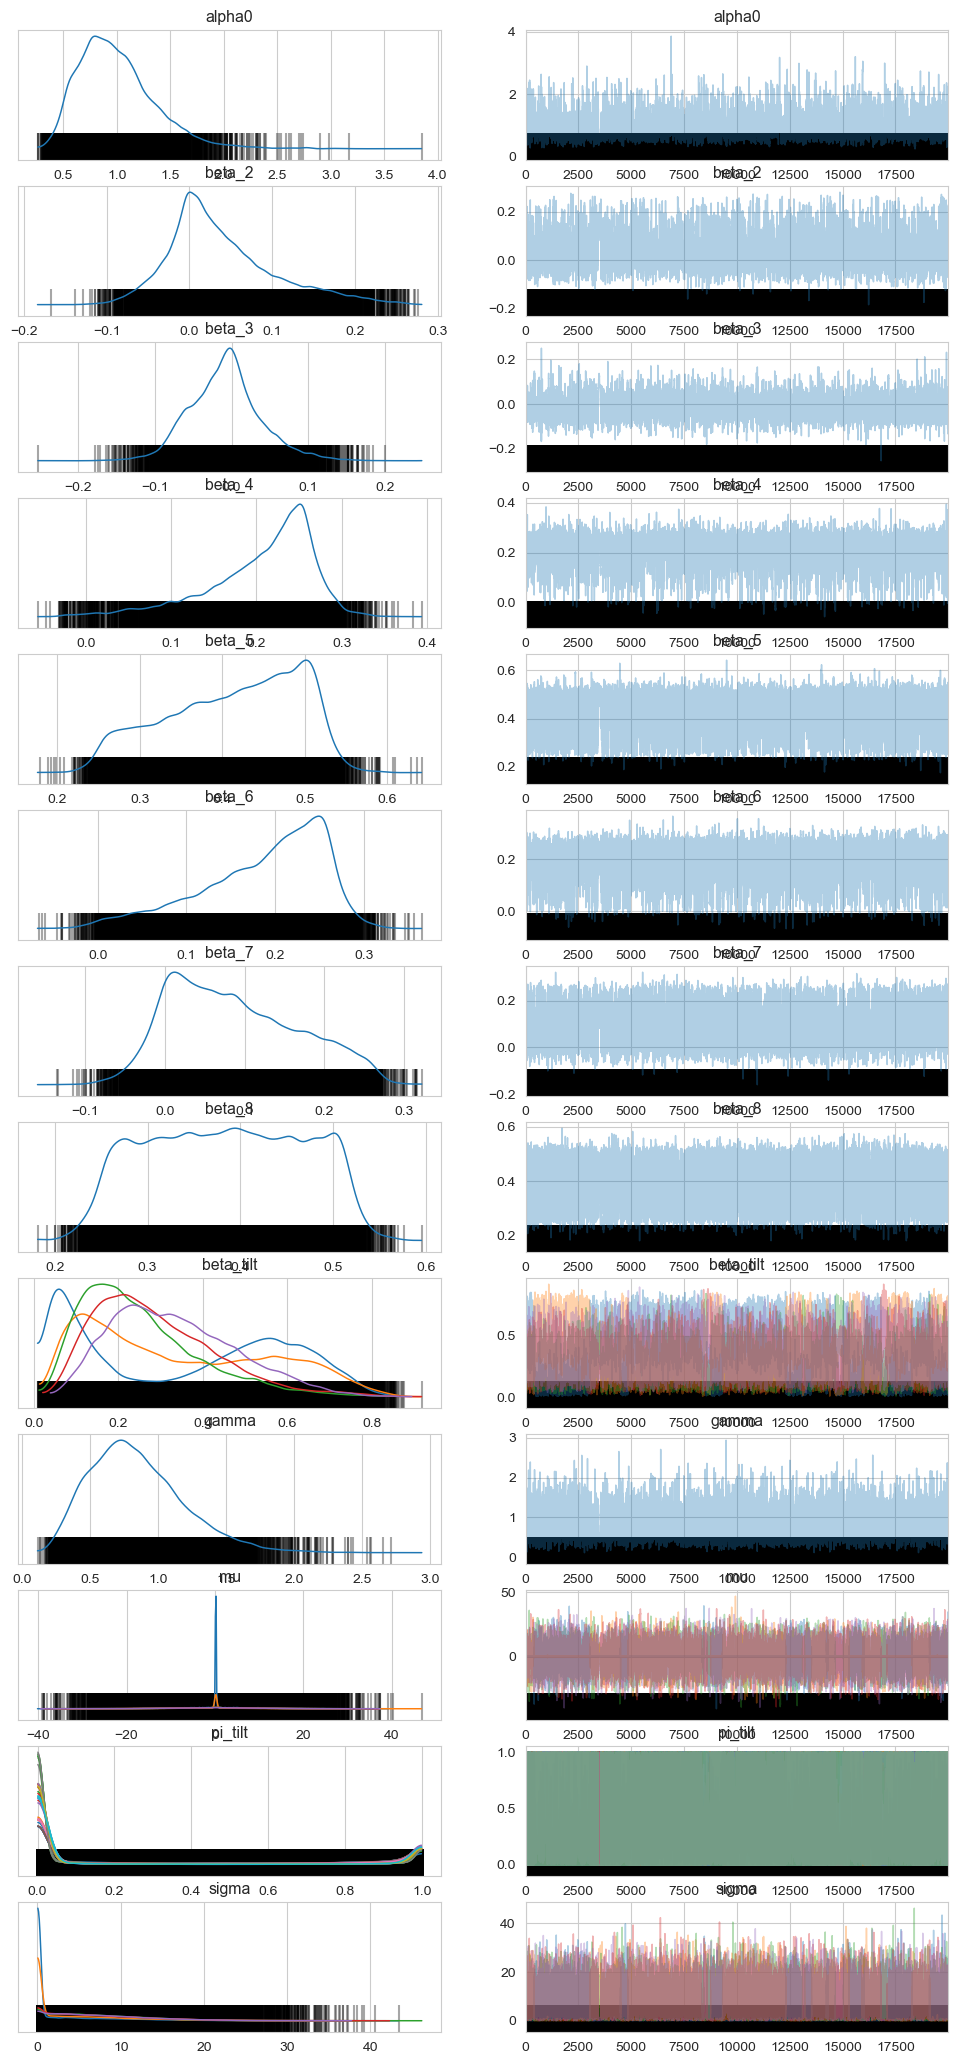

In [5]:
def stick_breaking(beta):
    rem = jnp.concatenate([jnp.array([1.]), jnp.cumprod(1-beta)[:-1]])
    return beta * rem

def reparameterize(pi):
    return pi / jnp.sum(pi)

def custom_loglike(beta, outcome_data_list):
    total_ll = 0.
    for outcome_data in outcome_data_list:
        x_vals = outcome_data[:,0]
        loglike_vals = outcome_data[:,1]
        total_ll += jnp.interp(beta, x_vals, loglike_vals)
    return total_ll

def HDP_model(source_outcome_data, num_outcomes_dict, N_sources, k, data_point_mean):
    gamma = numpyro.sample("gamma", dist.Gamma(1.0,5.0))
    alpha0 = numpyro.sample("alpha0", dist.Gamma(1.0,5.0))
    beta_tilt = numpyro.sample("beta_tilt", dist.Beta(1.,gamma).expand([k]))
    beta = stick_breaking(beta_tilt)
    beta_cum = jnp.cumsum(beta)
    pi_tilt = numpyro.sample(
        "pi_tilt",
        dist.Beta(alpha0*beta, alpha0*(1-beta_cum))
        .expand([N_sources,k])
    )
    pi_norms = []
    for s in range(N_sources):
        pi_s = stick_breaking(pi_tilt[s])
        pi_norms.append(reparameterize(pi_s))
    mu = numpyro.sample("mu", dist.Normal(0,10.).expand([k]))
    sigma = numpyro.sample("sigma", dist.HalfNormal(10.).expand([k]))
    for s in range(2, N_sources+1):
        mix = dist.MixtureSameFamily(
            dist.Categorical(probs=pi_norms[s-1]),
            dist.Normal(loc=mu, scale=sigma)
        )
        beta_s = numpyro.sample(f"beta_{s}", mix)
        grid_min = jnp.min(source_outcome_data[s][0][:,0])
        grid_max = jnp.max(source_outcome_data[s][-1][:,0])
        beta_clipped = jnp.clip(beta_s, grid_min, grid_max)
        ll = custom_loglike(beta_clipped, source_outcome_data[s])
        numpyro.factor(f"loglike_{s}", ll)

# 5) Run MCMC just as before
rng_key = random.PRNGKey(0)
data_point_mean = df_sim["point"].mean()
k = 5

nuts = NUTS(HDP_model)
mcmc = MCMC(nuts, num_warmup=5000, num_samples=20000)
mcmc.run(
    rng_key,
    source_outcome_data=source_outcome_data,
    num_outcomes_dict=num_outcomes_dict,
    N_sources=N_sources,
    k=k,
    data_point_mean=data_point_mean
)

mcmc.print_summary()
idata = az.from_numpyro(mcmc)
az.plot_trace(idata)

# Prior predictive checks

C:\Users\10191\AppData\Local\Temp\ipykernel_11172\1593685776.py:37: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  p   = p / trapz(p, x)            # normalise


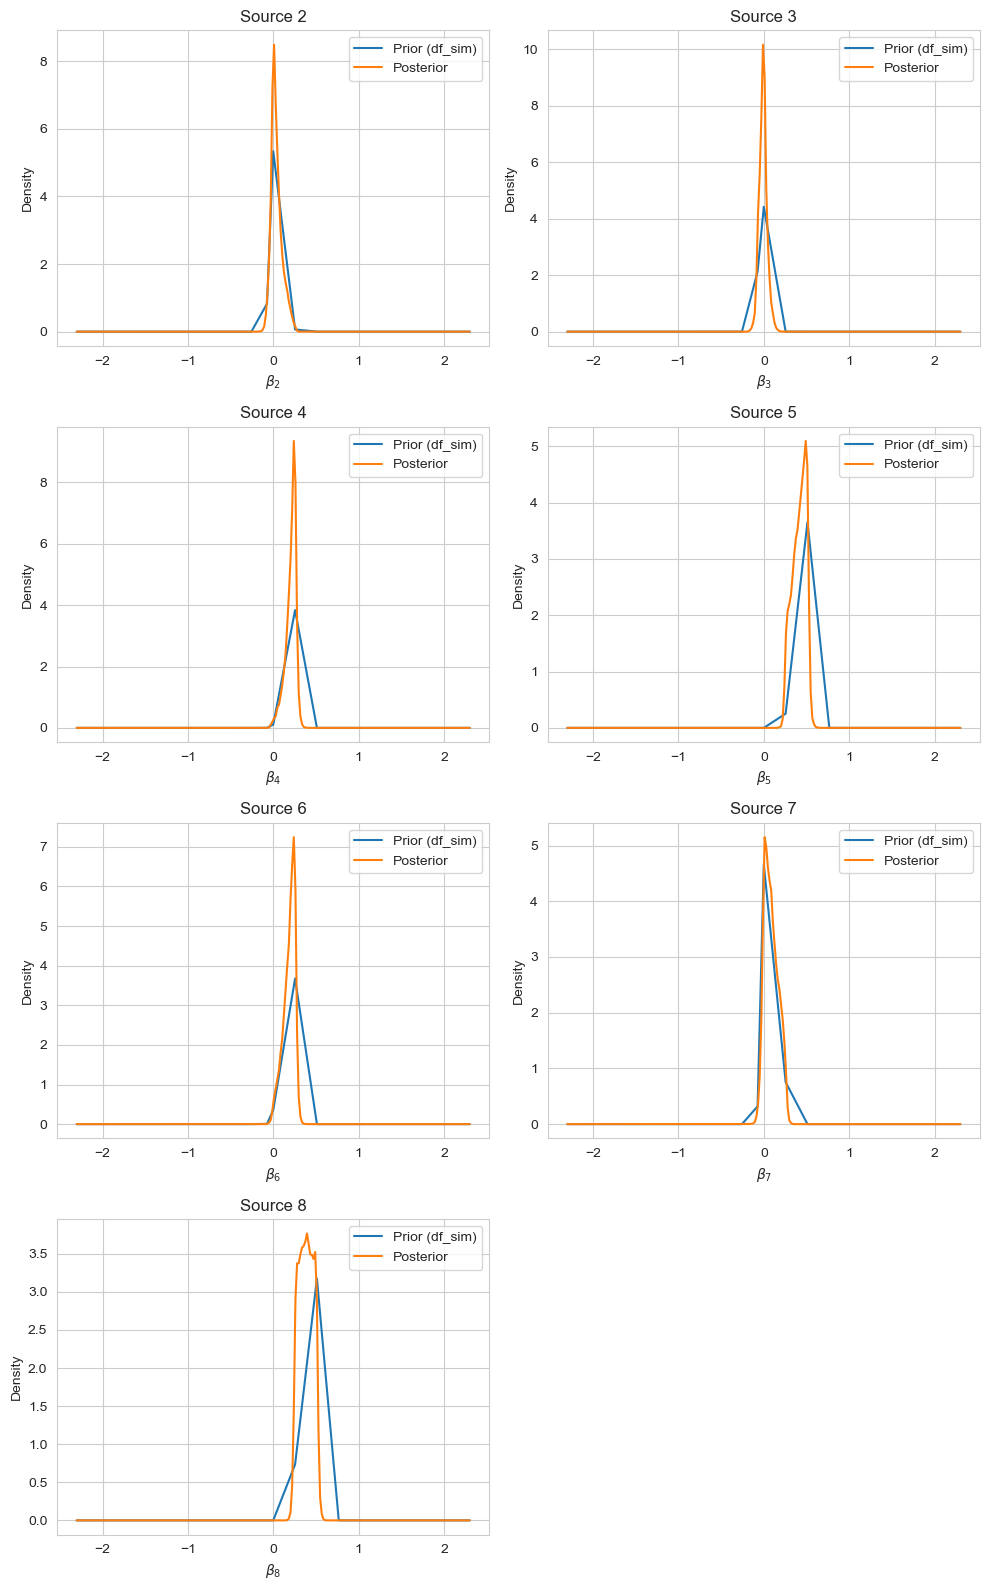

In [11]:
###############################################################################
#  PRIOR–POSTERIOR DENSITY CHECK  (prior taken **directly** from df_sim)
#  ---------------------------------------------------------------------------
#  • Uses the profile–likelihood values in `df_sim` as an *empirical prior*
#  • Extracts posterior samples β_s from `idata`
#  • Overlays the two densities for every source that appears in `idata`
###############################################################################
import re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.stats     import gaussian_kde
from scipy.integrate import trapz

def plot_df_prior_vs_posterior(df_sim, idata):
    """
    Parameters
    ----------
    df_sim : DataFrame
        Columns: ['source','outcome','point','value'] where 'value' is log-likelihood
    idata  : arviz.InferenceData
        From az.from_numpyro(mcmc); must contain `beta_<s>` variables
    """
    # ---- 1) WHICH β_s ARE IN THE POSTERIOR? ----
    beta_vars   = [v for v in idata.posterior.data_vars if re.fullmatch(r"beta_\d+", v)]
    sources_avl = sorted(int(v.split("_")[1]) for v in beta_vars)
    if not sources_avl:
        raise ValueError("No beta_* variables found in idata.posterior")

    # ---- 2) PRE-COMPUTE EMPIRICAL PRIOR DENSITIES FROM df_sim ----
    prior_dens  = {}   #   {s: (x_grid, p_density)}
    for s in sources_avl:
        sub = df_sim[df_sim["source"] == s]
        # sum over outcomes at each grid point
        g   = sub.groupby("point")["value"].sum().sort_index()
        x   = g.index.to_numpy()
        ll  = g.values
        ll  = ll - ll.max()              # stabilise exponentiation
        p   = np.exp(ll)
        p   = p / trapz(p, x)            # normalise
        prior_dens[s] = (x, p)

    # ---- 3) POSTERIOR KDES ----
    post_beta   = {s: idata.posterior[f"beta_{s}"].values.flatten()
                   for s in sources_avl}
    kde_post    = {s: gaussian_kde(post_beta[s]) for s in sources_avl}

    # ---- 4) PLOT ----
    n = len(sources_avl)
    ncols, nrows = 2, int(np.ceil(n / 2))
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 4 * nrows))
    axes = axes.flatten()

    for idx, s in enumerate(sources_avl):
        x_prior, p_prior = prior_dens[s]
        xmin = min(x_prior.min(),  post_beta[s].min())
        xmax = max(x_prior.max(),  post_beta[s].max())
        xgrid = np.linspace(xmin, xmax, 240)

        axes[idx].plot(x_prior, p_prior,              label="Prior (df_sim)")
        axes[idx].plot(xgrid, kde_post[s](xgrid),     label="Posterior")
        axes[idx].set_title(f"Source {s}")
        axes[idx].set_xlabel(rf"$\beta_{{{s}}}$")
        axes[idx].set_ylabel("Density")
        axes[idx].legend()
        axes[idx].grid(True)

    for ax in axes[n:]:
        ax.axis("off")

    fig.tight_layout()
    plt.show()
plot_df_prior_vs_posterior(df_sim, idata)
